# Exercise sheet

Some general remarks about the exercises:
* For your convenience functions from the lecture are included below. Feel free to reuse them without copying to the exercise solution box.
* For each part of the exercise a solution box has been added, but you may insert additional boxes. Do not hesitate to add Markdown boxes for textual or LaTeX answers (via `Cell > Cell Type > Markdown`). But make sure to replace any part that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove the `raise NotImplementedError()`.
* Please make your code readable by humans (and not just by the Python interpreter): choose informative function and variable names and use consistent formatting. Feel free to check the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/) for the widely adopted coding conventions or [this guide for explanation](https://realpython.com/python-pep8/).
* Make sure that the full notebook runs without errors before submitting your work. This you can do by selecting `Kernel > Restart & Run All` in the jupyter menu.
* For some exercises test cases have been provided in a separate cell in the form of `assert` statements. When run, a successful test will give no output, whereas a failed test will display an error message.
* Each sheet has 100 points worth of exercises. Note that only the grades of sheets number 2, 4, 6, 8 count towards the course examination. Submitting sheets 1, 3, 5, 7 & 9 is voluntary and their grades are just for feedback.

Please fill in your name here:

In [1]:
NAME = "Kees van Kempen"
NAMES_OF_COLLABORATORS = ""

---

**Exercise sheet 4**

Code from the lectures:

In [2]:
import numpy as np
import matplotlib.pylab as plt
import networkx as nx

rng = np.random.default_rng()
%matplotlib inline

def draw_transition_graph(P):
    # construct a directed graph directly from the matrix
    graph = nx.DiGraph(P)        
    # draw it in such a way that edges in both directions are visible and have appropriate width
    nx.draw_networkx(graph,connectionstyle='arc3, rad = 0.15',width=[6*P[u,v] for u,v in graph.edges()])

def sample_next(P,current):
    return rng.choice(len(P),p=P[current])

def sample_chain(P,start,n):
    chain = [start]
    for _ in range(n):
        chain.append(sample_next(P,chain[-1]))
    return chain

def stationary_distributions(P):
    eigenvalues, eigenvectors = np.linalg.eig(np.transpose(P))
    # make list of normalized eigenvectors for which the eigenvalue is very close to 1
    return [eigenvectors[:,i]/np.sum(eigenvectors[:,i]) for i in range(len(eigenvalues)) 
              if np.abs(eigenvalues[i]-1) < 1e-10]

def markov_sample_mean(P,start,function,n):
    total = 0
    state = start
    for _ in range(n):
        state = sample_next(P,state)
        total += function[state]
    return total/n

## Markov Chain on a graph

**(50 points)**

The goal of this exercise is to use Metropolis-Hastings to sample a uniform vertex in a (finite, undirected) connected graph $G$. More precisely, the state space $\Gamma = \{0,\ldots,n-1\}$ is the set of vertices of a graph and the desired probability mass function is $\pi(x) = 1/n$ for $x\in\Gamma$. The set of edges is denoted $E = \{ \{x_1,y_1\}, \ldots,\{x_k,y_k\}\}$, $x_i,y_i\in\Gamma$, and we assume that there are no edges connecting a vertex with itself ($x_i\neq y_i$) and there is at most one edge between any pair of vertices. The **neighbors** of a vertex $x$ are the vertices $y\neq x$ such that $\{x,y\}\in E$. The **degree** $d_x$ of a vertex $x$ is its number of neighbours. An example is the following graph:

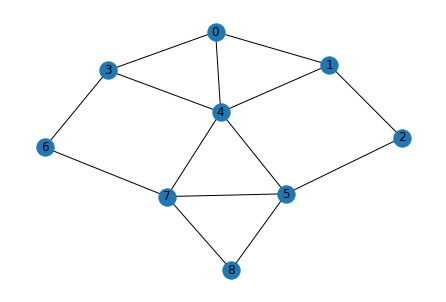

In [3]:
edges = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,4),(4,5),(3,6),(4,7),(5,8),(6,7),(7,8),(5,7),(0,4)]
example_graph = nx.Graph(edges)
nx.draw(example_graph,with_labels=True)

A natural proposal transition matrix is $Q(x \to y) = \frac{1}{d_x} \mathbf{1}_{\{\{x,y\}\in E\}}$. In other words, when at $x$ the proposed next state is chosen uniformly among its neighbors.

__(a)__ Write a function `sample_proposal` that, given a (networkX) graph and node $x$, samples $y$ according to transition matrix $Q(x \to y)$. _Hint_: a useful Graph member function is [`neighbors`](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.neighbors.html). **(10 pts)**

In [4]:
def sample_proposal(graph,x):
    '''Pick a random node y from the neighbors of x in graph with uniform
    probability, according to Q.'''
    y_list = np.fromiter(graph.neighbors(x), dtype=int)
    return rng.choice(y_list)

In [5]:
from nose.tools import assert_almost_equal
assert sample_proposal(nx.Graph([(0,1)]),0)==1
assert_almost_equal([sample_proposal(example_graph,3) for _ in range(1000)].count(4),333,delta=50)
assert_almost_equal([sample_proposal(example_graph,8) for _ in range(1000)].count(5),500,delta=60)

__(b)__ Let us consider the Markov chain corresponding to the transition matrix $Q(x \to y)$. Produce a histogram of the states visited in the first ~20000 steps. Compare this to the exact stationary distribution found by the function `stationary_distributions` from the lecture applied to the transition matrix $Q$. _Hint_: another useful Graph member function is [`degree`](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.degree.html). **(15 pts)**

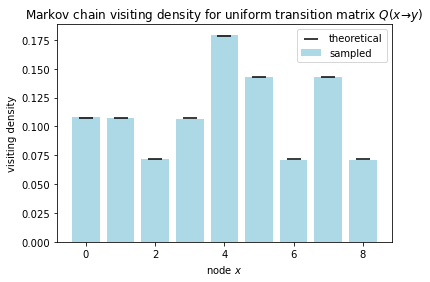

In [6]:
def chain_Q_histogram(graph,start,k):
    '''Produce a histogram (a Numpy array of length equal to the number of 
    nodes of graph) of the states visited (excluding initial state) by the 
    Q Markov chain in the first k steps when started at start.'''
    n = graph.number_of_nodes()
    number_of_visits = np.zeros(n)
    x = start
    
    for _ in range(k):
        x = sample_proposal(graph, x)
        number_of_visits[x] += 1
    
    return number_of_visits

def transition_matrix_Q(graph):
    '''Construct transition matrix Q from graph as two-dimensional Numpy array.'''
    n = example_graph.number_of_nodes()
    Q = np.zeros((n, n))
    for x in range(n): 
        for k in example_graph.neighbors(x):
            Q[x, k] = 1/example_graph.degree(x)
    return Q

# Compare histogram and stationary distribution in a plot
x_start = 1
k = 100000

plt.figure()
plt.title("Markov chain visiting density for uniform transition matrix $Q(x \\to y)$")
x_list = list(range(example_graph.number_of_nodes()))
plt.bar(x_list, chain_Q_histogram(example_graph, x_start, k)/k, color="lightblue", label="sampled")
plt.scatter(x_list, stationary_distributions(transition_matrix_Q(example_graph)), s=200, marker="_", color="black", label="theoretical")
plt.ylabel("visiting density")
plt.xlabel("node $x$")
plt.legend()
plt.show()

In [7]:
assert_almost_equal(transition_matrix_Q(example_graph)[3,4],1/3,delta=1e-9)
assert_almost_equal(transition_matrix_Q(example_graph)[3,7],0.0,delta=1e-9)
assert_almost_equal(transition_matrix_Q(example_graph)[2,2],0.0,delta=1e-9)
assert_almost_equal(np.sum(transition_matrix_Q(example_graph)[7]),1.0,delta=1e-9)
assert chain_Q_histogram(nx.Graph([(0,1)]),0,100)[1] == 50
assert len(chain_Q_histogram(example_graph,0,100)) == example_graph.number_of_nodes()

__(c)__ Determine the appropriate Metropolis-Hastings acceptance probability $A(x \to y)$ for $x\neq y$
and write a function that, given a graph and $x$, samples the next state with $y$ according to the Metropolis-Hastings transition matrix $P(x \to y)$. **(10 pts)**

In [8]:
def acceptance_probability(graph,x,y):
    '''Compute A(x -> y) for the supplied graph (assuming x!=y).'''
    assert x != y
    
    Q = transition_matrix_Q(graph)
    n = graph.number_of_nodes()
    # We want to sample a uniform mass distribution pi:
    pi = np.ones(n)/n
    
    if Q[x, y] == 0:
        return 0
    else:
        A = pi[y]*Q[y, x]/( pi[x]*Q[x, y] )
        return np.min([1., A])

def sample_next_state(graph,x):
    '''Return next random state y according to MH transition matrix P(x -> y).'''
    y = sample_proposal(graph, x)
    return y if rng.random() < acceptance_probability(graph, x, y) else x

In [9]:
assert_almost_equal(acceptance_probability(example_graph,3,4),0.6,delta=1e-9)
assert_almost_equal(acceptance_probability(example_graph,8,7),0.5,delta=1e-9)
assert_almost_equal(acceptance_probability(example_graph,7,8),1.0,delta=1e-9)
assert_almost_equal(acceptance_probability(nx.Graph([(0,1)]),0,1),1,delta=1e-9)

__(d)__ Do the same as in part (b) but now for the Markov chain corresponding to $P$. Verify that the histogram of the Markov chain approaches a flat distribution and corroborate this by calculating the explicit matrix $P$ and applying `stationary_distributions` to it. _Hint_: for determining the explicit matrix $P(x\to y)$, remember that the formula $P(x\to y) = Q(x\to y)A(x\to y)$ only holds for $x\neq y$. What is $P(x\to x)$? **(15 pts)**

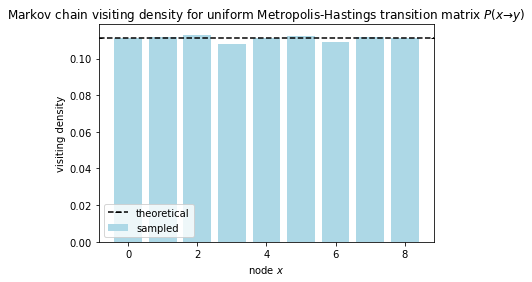

In [10]:
def chain_P_histogram(graph,start,k):
    '''Produce a histogram of the states visited (excluding initial state) 
    by the P Markov chain in the first n steps when started at start.'''
    n = graph.number_of_nodes()
    number_of_visits = np.zeros(n)
    x = start
    
    for _ in range(k):
        x = sample_next_state(graph, x)
        number_of_visits[x] += 1
    
    return number_of_visits

def transition_matrix_P(graph):
    '''Construct transition matrix Q from graph as numpy array.'''
    n = graph.number_of_nodes()
    P = np.zeros((n, n))
    Q = transition_matrix_Q(graph)
    
    for x in range(n):
        for y in range(n):
            if x != y:
                P[y, x] = Q[x, y]*acceptance_probability(graph, x, y)
        # Finally, we have to calculate P(x -> x):
        P[x, x] = 1 - np.sum(P[:, x])
    return P

# plotting
x_start = 1
k = 40000

plt.figure()
plt.title("Markov chain visiting density for uniform Metropolis-Hastings transition matrix $P(x \\to y)$")
x_list = list(range(example_graph.number_of_nodes()))
plt.bar(x_list, chain_P_histogram(example_graph, x_start, k)/k, color="lightblue", label="sampled")
plt.axhline(y = 1/example_graph.number_of_nodes(), marker="_", linestyle = "dashed", color="black", label="theoretical")
plt.ylabel("visiting density")
plt.xlabel("node $x$")
plt.legend()
plt.show()

In [11]:
assert_almost_equal(transition_matrix_P(example_graph)[3,4],1/5,delta=1e-9)
assert_almost_equal(transition_matrix_P(example_graph)[3,7],0.0,delta=1e-9)
assert_almost_equal(transition_matrix_P(example_graph)[2,2],0.41666666,delta=1e-5)
assert_almost_equal(np.sum(transition_matrix_P(example_graph)[7]),1.0,delta=1e-9)

In [12]:
assert len(chain_P_histogram(example_graph,0,100)) == example_graph.number_of_nodes()
assert_almost_equal(chain_P_histogram(example_graph,0,20000)[8],2222,delta=180)

## MCMC simulation of disk model

**(50 points)**

Recall that in the disk model with we would like to sample the positions $x = (x_1,y_1,\ldots,x_N,y_N)\in [0,L)^{2N}$ of $N$ disks of radius $1$ in the torus $[0,L)^2$ with uniform density $\pi(x) = \mathbf{1}_{\{\text{all pairwise distance }\geq 2\}}(x) / Z$, where $Z$ is the unknown partition function of the model. We will assume $L > 2$ and $N\geq 1$. For the purposes of this simulation we will store the state $x$ in a `np.array` of dimension $(N,2)$ with values in $[0,L)$. Such a configuration can be conveniently plotted using the following function:

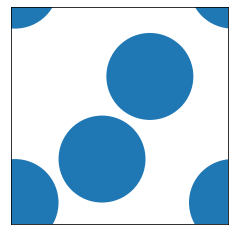

In [13]:
def plot_disk_configuration(positions,L):
    fig,ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_ylim(0,L)
    ax.set_xlim(0,L)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    for x,y in positions:
        # consider all horizontal and vertical copies that may be visible
        for x_shift in [z for z in x + [-L,0,L] if -1<z<L+1]:
            for y_shift in [z for z in y + [-L,0,L] if -1<z<L+1]:
                ax.add_patch(plt.Circle((x_shift,y_shift),1))
    plt.show()
    
# Example with N=3 and L=5
positions = np.array([[0.1,0.5],[2.1,1.5],[3.2,3.4]])
plot_disk_configuration(positions,5)

__(a)__ Write a function `two_disks_overlap` that tests whether disks at position $\mathbf{x}_1 \in [0,L)^{2}$ and position $\mathbf{x}_2 \in [0,L)^{2}$ overlap and a function `disk_config_valid` that checks whether a full configuration is valid (non-overlapping and non-touching). _Hint:_ The minimal separation in the $x$-direction can be expressed as a function of `x1[0]-x2[0]` and the minimal separation in the y-direction as a function of `x1[1]-x2[1]`. Then use pythagoras. **(15 pts)**

In [14]:
def two_disks_overlap(x1,x2,L):
    '''Return True if the disks centered at x1 and x2 (represented as 2-element arrays) overlap in [0,L)^2.'''
    # To take into account all overlap with the boundaries, we will also
    # test shifted disks. As d(x1 + d, x2) = d(x1, x2 - d), we do not have
    # to shift both disks explicitly.
    for dx in [0, -L, L]:
        for dy in [0, -L, L]:
            if (x1[0] - x2[0] + dx)**2 + (x1[1] - x2[1] + dy)**2 <= 4:
                return True
    return False
    
def disk_config_valid(x,L):
    '''Return True if the configuration x (as two-dimensional array) is non-overlapping in [0,L)^2.'''
    n = len(x)
    for idx_x1 in range(n):
        # We should not compare x1 with itself, and the previous disks have
        # already been compared.
        for idx_x2 in range(idx_x1 + 1, n):
            if two_disks_overlap(x[idx_x1], x[idx_x2], L):
                return False
    return True

In [15]:
assert two_disks_overlap(np.array([1,1]),np.array([1,1]),5)
assert two_disks_overlap(np.array([0.6,0.6]),np.array([4.1,0.5]),5)
assert two_disks_overlap(np.array([0.3,0.3]),np.array([4.6,4.6]),5)
assert not two_disks_overlap(np.array([1,1]),np.array([3.1,1]),7)
assert not two_disks_overlap(np.array([1,1]),np.array([1,3.1]),7)
assert not two_disks_overlap(np.array([1,1]),np.array([1.01+np.sqrt(2),1.01+np.sqrt(2)]),6)
assert two_disks_overlap(np.array([1,1]),np.array([0.99+np.sqrt(2),0.99+np.sqrt(2)]),6)

In [16]:
assert disk_config_valid(np.array([[0.1,0.5],[2.1,1.5],[3.2,3.4]]),5)
assert not disk_config_valid(np.array([[0.1,0.5],[2.1,1.5],[3.2,3.4],[4.1,2.3]]),5)
assert disk_config_valid(np.array([[1,1],[3.1,1],[1,3.1]]),6)
assert not disk_config_valid(np.array([[1,1],[3.1,1],[1,3.1],[2.5,2.5]]),6)

__(b)__ Assuming $N \leq \lceil \frac12 L -1 \rceil^2$ where $\lceil r\rceil$ is the smallest integer larger or equal to $r$, write a function `generate_initial_positions` that produces an arbitrary non-overlapping (and non-touching) initial condition given $N$ and $L$. The layout need not be random, any deterministic layout is ok (e.g. grid). **(10 pts)**

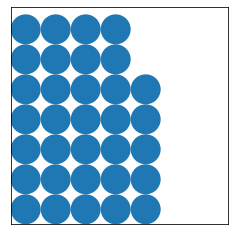

In [17]:
def generate_initial_positions(N,L):
    '''Return array of positions of N disks in non-overlapping positions.'''
    assert N <= np.ceil( (.5*L**2 - 1)**2 )
    
    disks = np.zeros((N, 2))
    i = 0
    # To have the disks non-touchting, we have them 2.0001 apart instead of 2.
    for x in np.arange(1, L - 1, 2.0001):
        for y in np.arange(1, L - 1, 2.0001):
            if i + 1 > N: return disks
            disks[i] = x, y
            i += 1
    return disks
    
plot_disk_configuration(generate_initial_positions(33,14.5),14.5)

In [18]:
for l in [4,9.2,14.5]:
    for n in range(1,int(np.ceil(l/2-1)**2)+1):
        assert disk_config_valid(generate_initial_positions(n,l),l), "Failed for n = {}, l = {}".format(n,l)

__(c)__ Write a function `remains_valid_after_move` that determines whether in a non-overlapping configuration $x$ moving the $i$th disk to `next_position` results in a valid non-overlapping configuration. **(10 pts)**

In [19]:
def remains_valid_after_move(x,i,next_position,L):
    '''Returns True if replacing x[i] by next_position would yield a valid configuration,
    otherwise False.'''
    # We need to create a copy as not to alter the original x
    # outside this function.
    #
    # NOTE: The copying in this function is the heaviest operation.
    # Reducing this overhead would be great, but I am not familiar
    # enough with references/pointers in Python.
    copy_x = np.copy(x)
    copy_x[i] = next_position
    return disk_config_valid(copy_x, L)

In [20]:
assert remains_valid_after_move([[0.1,0.5],[2.1,1.5],[3.2,3.4]],0,[4.5,0.5],5)
assert not remains_valid_after_move([[0.1,0.5],[2.1,1.5],[3.2,3.4]],1,[4.5,0.5],5)
assert not remains_valid_after_move([[0.1,0.5],[2.1,1.5],[3.2,3.4]],2,[3.2,2.5],5)
assert remains_valid_after_move([[0.1,0.5],[2.1,1.5],[3.2,3.4]],2,[3.2,3.8],5)

__(d)__ Implement the Metropolis-Hastings transition by selecting a uniformly chosen disk and displacing it by $ (\delta\,\mathcal{N}_1,\delta\,\mathcal{N}_2)$ where $\delta>0$ is a parameter and $\mathcal{N}_i$ are independent normal random variables (make sure to keep positions within $[0,L)^2$ by taking the new position modulo $L$). Test run your simulation for $L=11.3$ and $N=20$ and $\delta = 0.3$ and about $10000$ Markov chain steps and plot the final state. **(15 pts)**

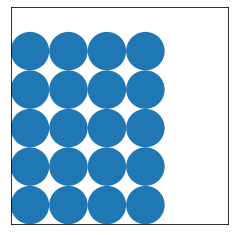

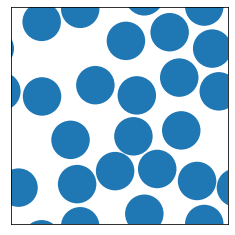

Of 10000 proposed moves, 5106 were taken (51.1%).


In [21]:
def MH_disk_move(x,L,delta):
    '''Perform random MH move on configuration x, thus changing the array x (if accepted). 
    Return True if move was accepted, False otherwise.'''
    
    # Although it is tempting to use the wacky method of pulling two independent
    # normal RVs using the method developed two weeks ago, let's just use Numpy.
    N1, N2 = rng.normal(), rng.normal()
    n = len(x)
    i = np.floor(rng.random()*n).astype(int)
    new_position = x[i] + delta*np.array([N1, N2])
    new_position %= L
    
    if remains_valid_after_move(x, i, new_position, L):
        x[i] = new_position
        return True
    return False
    
# Test run and plot resulting configuration
steps = 10000
num_moves = 0

L = 11.3
N = 20
delta = .3

x = generate_initial_positions(N, L)
plot_disk_configuration(x, L)

for _ in range(steps):
    num_moves += MH_disk_move(x, L, delta)

plot_disk_configuration(x, L)
print("Of {} proposed moves, {} were taken ({:.1f}%).".format(steps, num_moves, num_moves/steps*100))